# Titanic example

This notebook illustrate a toy example, with three passengers, and uses a squared distance classifier, inspired by Machine Learning with Quantum Computers by Schuld and Petruccione, to predict if a passenger will survive the 2021 Titanic disaster.

Two of the three passengers are the training set.  One survived and one died. The aim is to predict the fate of the third passenger in the mini-test set.  

Data is given for all three passengers consisting of a cabin number, assumed to be between 1 and 2,500, and a ticket price, assumed to be between £1 and £10,000, stored in a vector $\bf{x_m}$ for the training data, and $\bf{x}$ for the test data.  A nearest neighbour classifier is used to classify the third passenger, with $$p(y=1|\bf{x}) = \frac{1}{\chi} \frac{1}{M_1} \sum_{m|y^m = 1}\left( 1 - \frac{1}{c}\|\bf{x} - \bf{x^m} \|^2\right)$$

where $M_1$ is the sum over all training inputs labeled with $y_m$ = 1, $c$ is an arbitary constant, and $\chi$ is a normalisation factor to ensure $p(y = 0|\bf{x}) + p(y = 1|\bf{x}) = 1$

Import modules needed:

In [ ]:
from pathlib import Path
import numpy as np
import math
import pennylane as qml
from functools import partial

HOME_DIR = '..'
BASE_DIR = Path(HOME_DIR)

import sys
sys.path.append(HOME_DIR)

from config.config import DATA, SHOTS, C
PROJECT = '01_titanic'
FOLDER = 'processed'
FILE = 'processed_data.csv'

from src.modules.data_helper_functions import (read_csv, 
                                              clean_and_print_data,
                                              find_gamma_m, 
                                              normalise,
                                              find_norm,
                                              find_test_data,
                                              pre_process_feature_vector,
                                              prepare_quantum_feature_vector,
                                              normalise_feature_vector,
                                              )

from src.modules.graph_functions import plot_simple_scatter

from src.modules.quantum_helper_functions import make_wires

Load the data, clean and print

In [2]:
file_path = BASE_DIR.joinpath(DATA).joinpath(PROJECT).joinpath(FOLDER).joinpath(FILE)
print(f'Data will be loaded from {file_path}')
data = read_csv(file_path)
print(f'\nThe raw data is:')
for items in data:
    print(items)

labels, x1, x2, y = clean_and_print_data(data)

Data will be loaded from ..\data\01_titanic\processed\processed_data.csv

The raw data is:
{'passenger': 'Passenger1', 'raw_price': '8500', 'raw_cabin': '910', 'price': '0.85', 'cabin': '0.364', 'survived': '1'}
{'passenger': 'Passenger2', 'raw_price': '1200', 'raw_cabin': '2105', 'price': '0.12', 'cabin': '0.842', 'survived': '0'}
{'passenger': 'Passenger3', 'raw_price': '7800', 'raw_cabin': '1121', 'price': '0.78', 'cabin': '0.4484', 'survived': ''}

After loading the data into lists we have:
labels = ['Passenger1', 'Passenger2', 'Passenger3']
x1 = [0.85, 0.12, 0.78]
x2 = [0.364, 0.842, 0.4484]
y - classification result [1, 0, '']


Plot data

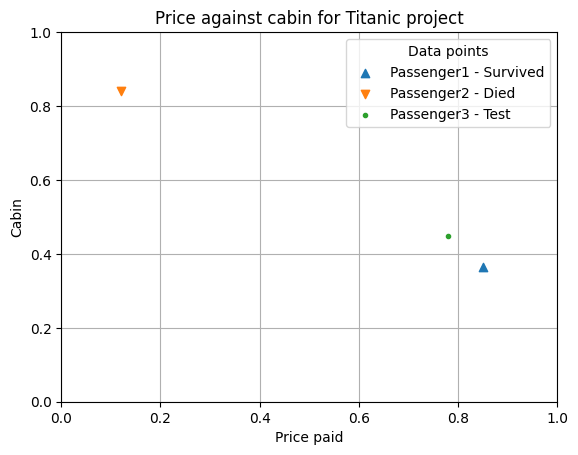

In [3]:
plot_simple_scatter(x1, x2, labels, y)

## Calculate the square distance classifier:

Normalise and print the data:


The normalised feature values are:
x1=['0.919', '0.141', '0.867']
x2=['0.394', '0.990', '0.498']
y=[1, 0, '']


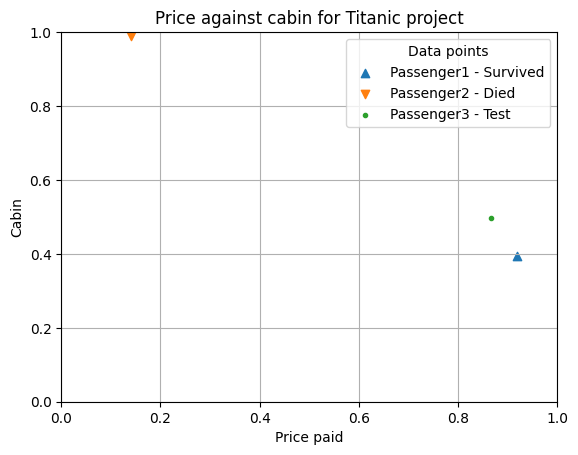

In [4]:
x1, x2 = normalise(x1, x2)
print(f'\nThe normalised feature values are:')
print(f'x1={[f'{v:.3f}' for v in x1]}\r')
print(f'x2={[f'{v:.3f}' for v in x2]}\r')
print(f'y={y}')
plot_simple_scatter(x1, x2, labels, y)

Find the test data:

In [ ]:
for i, items in enumerate(y):
    if items == '':
        x = np.array([x1[i],x2[i]])
if x.shape != (2,):
    raise Exception(f'x,shape should be (2,), is {x.shape}')
print(f'The test point is {x}')

x = find

The test point is [0.86695433 0.49838759]


Calculate $p(y = 0|\bf{x})$ and $p(y = 1|\bf{x})$, and print results

In [6]:
M0, M1, p0, p1 = 0, 0, 0, 0
for i, item in enumerate(y):
    x_m = np.array([x1[i],x2[i]])
    print(f'\nProcessing training point {x_m} with label {item}, {i=}:')
    if item == 1:
        M1 += 1
        p1 += find_gamma_m(x, x_m, C)
        print(f'For point {x_m} gamma_m with a passenger who survived at point {x} is {p1:.3f}.')
    elif item == 0:
        M0 += 1
        p0 += find_gamma_m(x, x_m, C)
        print(f'For point {x_m} gamma_m with a passenger who died at point {x} is {p0:.3f}.')
    elif item != '':
        raise Exception('Value of y is {item} which is not allowed') 
    
p0, p1 = p0/M0, p1/M1 # find average value
#normalise
chi = p0 + p1
p0, p1 = p0/chi, p1/chi

print(f'The probability that the test passenger dies is {p0:.1%}.')
print(f'The probability that the test passenger survives is {p1:.1%}.')

if p1 > p0:
    print('The classifier predicts survival!')
else:
    print('The classifier predicts death!')


Processing training point [0.91925687 0.39365824] with label 1, i=0:
Finding gamma_m for x=[0.86695433 0.49838759] and xm=[0.91925687 0.39365824] with c=4
gamma_m=0.996574051595997
For point [0.91925687 0.39365824] gamma_m with a passenger who survived at point [0.86695433 0.49838759] is 0.997.

Processing training point [0.14109213 0.98999647] with label 0, i=1:
Finding gamma_m for x=[0.86695433 0.49838759] and xm=[0.14109213 0.98999647] with c=4
gamma_m=0.8078611958852596
For point [0.14109213 0.98999647] gamma_m with a passenger who died at point [0.86695433 0.49838759] is 0.808.

Processing training point [0.86695433 0.49838759] with label , i=2:
The probability that the test passenger dies is 44.8%.
The probability that the test passenger survives is 55.2%.
The classifier predicts survival!


Normalise, print and plot

Prepare the data ready to load into a quantum computer
- Add an extra copy of the features of Passsenger 3, and 
- tidy up y to be integer

In [7]:
x1, x2, y = pre_process_feature_vector(x1, x2, y)
alpha = prepare_quantum_feature_vector(x1, x2, y)
features= normalise_feature_vector(alpha)

After pre-processing feature vector:
Added extra copy of Passenger 3 and tidy up y to be integers
x1=['0.919', '0.141', '0.867', '0.867']
x2=['0.394', '0.990', '0.498', '0.498']
y=[1, 0, 1, 0] 

After preparing quantum feature vector: 
alpha=['0.000', '0.919', '0.000', '0.394', '0.141', '0.000', '0.990', '0.000', '0.000', '0.867', '0.000', '0.498', '0.867', '0.000', '0.498', '0.000']
Norm before normalisation = 2.0
After normalisation: 
alpha_norm=['0.000', '0.460', '0.000', '0.197', '0.071', '0.000', '0.495', '0.000', '0.000', '0.433', '0.000', '0.249', '0.433', '0.000', '0.249', '0.000']


Prepare a complete feature vector

In [8]:
norm = float(find_norm(features))
if norm != 1.0:
    raise Exception(f'Normalisation failed, norm = {norm}')

Find the number of qubits required.

In [9]:
n_qubits = math.ceil(math.log2(len(features)))
if n_qubits != math.log2(len(features)):
    raise Exception(f'The number of features must be a power of 2, not {len(features)}, n_qubits = {n_qubits}')
print(f'Number of qubits required = {n_qubits}')

Number of qubits required = 4


In [10]:
my_wires = make_wires(n_qubits)
dev = qml.device("default.qubit", wires=n_qubits)

In [11]:
dev_unique_wires = qml.device('default.qubit', wires=my_wires)

In [12]:
@partial(qml.set_shots, shots=SHOTS)
@qml.qnode(dev_unique_wires)
def circuit(features):
    qml.AmplitudeEmbedding(features, wires=my_wires, normalize=False)

    # Apply Hadamard on the first qubit (wire 'q1')
    qml.Hadamard(wires='q1')

    # Post-select on measuring 0 on wire 'q1'
    m_0 = qml.measure('q1', postselect=0)

    return qml.probs(wires=['q4'])

In [13]:
result = circuit(features)
print(f'The result of the quantum circuit is {result}.')
print(f'The results of the quantum classifier are: \r ')
print(f'The probality of survival is {result[1]:.1%}, and death is {result[0]:.1%}.')


The result of the quantum circuit is [0.4335512 0.5664488].
 he results of the quantum classifier are: 
The probality of survival is 56.6%, and death is 43.4%.


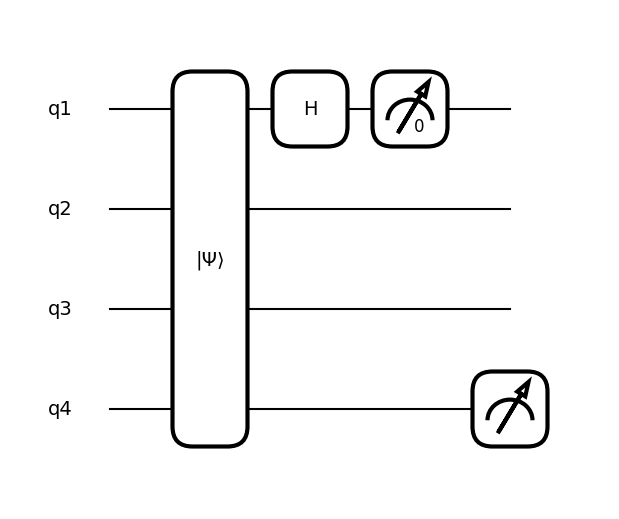

In [14]:
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(circuit)(features)